#Progetto finale del corso "Machine Learning: tecniche avanzate"
## Face detection per Fotocamere digitali
## 12/04/2024
## Piero Corbelli

# 1. Faces images import

Si decide di utilizzare olivetti_faces perchè è un dataset semplice, con soli volti e facile da utilizzare per un addestramento, e che ha anche diversi orientamenti del viso.

In [1]:
!rm -rf olivetti_faces.zip
!rm -rf olivetti_faces
!rm -rf dataset
!wget https://github.com/ProfAI/machine-learning-modelli-e-algoritmi/raw/main/datasets/olivetti_faces.zip
!unzip olivetti_faces.zip

--2025-04-12 16:08:42--  https://github.com/ProfAI/machine-learning-modelli-e-algoritmi/raw/main/datasets/olivetti_faces.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ProfAI/machine-learning-modelli-e-algoritmi/main/datasets/olivetti_faces.zip [following]
--2025-04-12 16:08:43--  https://raw.githubusercontent.com/ProfAI/machine-learning-modelli-e-algoritmi/main/datasets/olivetti_faces.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 912321 (891K) [application/zip]
Saving to: ‘olivetti_faces.zip’

olivetti_faces.zip  100%[===================>] 890.94K  --.-KB/s    in 0.02s   

2025-04-12

Si importano le librerie necessarie:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline

import os
import cv2 #open CV module
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, log_loss

import shutil

from sklearn.svm import SVC

from skimage.feature import hog
from skimage import exposure

In [3]:
RANDOM_SEED = 0

# 2. Creation of the faces dataset

Viene creato un dataset delle immagini con i volti ("faces"), che è relativo alla classe 1 (True)

In [4]:
img = cv2.imread('olivetti_faces/0/0.jpg')
img.shape

(64, 64, 3)

In [5]:
if(not os.path.exists('dataset')):
  os.mkdir("dataset/")
  os.mkdir("dataset/faces")
  os.mkdir("dataset/no_faces")

In [6]:
for d in os.listdir('olivetti_faces/'):
  for im in os.listdir(f'olivetti_faces/{d}'):
    os.rename(f'olivetti_faces/{d}/{im}', f'olivetti_faces/{d}/{d}_{im}')
    #print(f'{d}_{im}')

In [7]:
for d in os.listdir('olivetti_faces/'):
  for im in os.listdir(f'olivetti_faces/{d}'):
    shutil.copy(f'olivetti_faces/{d}/{im}', f'dataset/faces/{im}')

In [8]:
len(os.listdir('dataset/faces'))

400

# 3. Download random images dataset

Si importa un dataset di immagini random da kaggle, che verranno usate come il dataset di immagini senza volti.

In [9]:
KAGGLE_USERNAME = "pcorbelli"
KAGGLE_KEY = "bee7d738b299cd959f80648360b455d0"

RANDOM_SEED = 0

In [10]:
os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

In [11]:
!kaggle datasets download -d lprdosmil/unsplash-random-images-collection
!kaggle datasets download -d jessicali9530/lfw-dataset

Dataset URL: https://www.kaggle.com/datasets/lprdosmil/unsplash-random-images-collection
License(s): CC0-1.0
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other


In [12]:
!unzip unsplash-random-images-collection.zip
!unzip lfw-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

# 4. Creation of the no-faces dataset

Viene creata la cartella "no-faces", che è il dataset relativo alla classe 0 (False).

In [13]:
RAND_IMG_DIR = '/content/unsplash-images-collection'

In [14]:
from random import sample

In [15]:
!rm -rf dataset/no_faces
os.mkdir("dataset/no_faces")

In [16]:
for im in os.listdir(RAND_IMG_DIR)[0:400]:#sample(os.listdir(RAND_IMG_DIR), 400):
  img = cv2.imread(RAND_IMG_DIR+ '/' + im)
  rnd_start = (np.random.randint(0, img.shape[0]-64), np.random.randint(0, img.shape[1]-64))
  start = rnd_start
  crop_img = img[start[0]:start[0]+64, start[1]:start[1]+64]
  cv2.imwrite(f'dataset/no_faces/{im}', crop_img)


In [17]:
len(os.listdir('dataset/no_faces/'))

400

In [18]:
def load_images(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        images.append(img)
        labels.append(0 if "no_faces" in path else 1) # 1 per facce, 0 no facce.
    return images, labels

#5. Creation of the HOG features and training of the SVM classifier

Per la creazione delle features viene utilizzato l'algoritmo Hystogram of Oriented Gradients. La scelta è stata operata anche grazie alla consultazione delle chat sui gruppi Discord. Dal seguente articolo sono state dedotte le migliori configurazioni dei parametri.

https://medium.com/@dnemutlu/hog-feature-descriptor-263313c3b40d

In [19]:
positive_images, positive_labels = load_images('dataset/faces/')
negative_images, negative_labels = load_images('dataset/no_faces/')

images = positive_images + negative_images
labels = positive_labels + negative_labels

win_size = images[0].shape
cell_size = (8, 8)
block_size = (16, 16)
block_stride = (8, 8)
num_bins = 9

# Estrazione delle features HOG
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
hog_features = []
for image in images:
    hog_feature = hog.compute(image)
    hog_features = np.append(hog_features, hog_feature)
hog_features = hog_features.reshape(len(images), -1)

# Creazione della pipeline
face_detection_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', probability = True)
    )

# 3. Addestramento del classificatore SVM
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.3, random_state=42)
face_detection_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

In [20]:
print(classification_report(y_test, face_detection_pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       115
           1       1.00      1.00      1.00       125

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



Tutti gli score sono perfetti, sia sul dataset di training che su quello di test, questo potrebbe indicare overfitting. Per questo si va a fare una cross validation.

In [21]:
def cross_validate_model(model, X, y, n_splits=5, random_state=RANDOM_SEED):
  train_acc_score = []
  test_acc_score = []
  train_prec_score = []
  test_prec_score = []

  kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    model.fit(X_train, y_train)

    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    precision_train = precision_score(y_train, model.predict(X_train))
    precision_test = precision_score(y_test, model.predict(X_test))

    train_acc_score.append(accuracy_train)
    test_acc_score.append(accuracy_test)
    train_prec_score.append(precision_train)
    test_prec_score.append(precision_test)

  scores = {
      "train_accuracy": np.array(train_acc_score),
      "test_accuracy": np.array(test_acc_score),
      "train_precision": np.array(train_prec_score),
      "test_precision": np.array(test_prec_score)
  }

  return scores

In [22]:
scores_svm = cross_validate_model(face_detection_pipeline, X=hog_features, y=labels, n_splits=5, random_state=RANDOM_SEED)
print(scores_svm)


{'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_accuracy': array([1., 1., 1., 1., 1.]), 'train_precision': array([1., 1., 1., 1., 1.]), 'test_precision': array([1., 1., 1., 1., 1.])}


Non sembra esserci overfitting, il modello fitta perfettamente, forse anche per la poca varietà di immagini utilizzate per la classe no-faces (probabilmente non ci sono immagini che ingannano il classificatore).

#5. Creation of the functions for returning the bounding boxes list

Vengono create nell'ordine:
- Una non max suppression, che sceglie il migliore tra i rettangoli sovrapposti rilevati dallo sliding window, utilizzando anche la probabilità del classificatore.
- Lo sliding window che applica il classificatore iterativamente su tutta l'immagine con dimensioni variabili della finestra, andando a riconoscere le finestre in cui si trovano i volti.

Per realizzare queste funzioni si è ricorso anche all'ausilio di Gemini AI.

In [23]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # Se non ci sono bounding box, restituisci una lista vuota
    if len(boxes) == 0:
        return []

    # Se i bounding box sono interi, convertili in float
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # Inizializza la lista dei bounding box selezionati
    pick = []

    # Prendi le coordinate dei bounding box
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    # Se ci sono delle probabilità, ordinali in ordine decrescente
    if probs is not None:
        idxs = np.argsort(probs)[::-1]
    # Altrimenti, ordina i bounding box in base alla coordinata y inferiore
    else:
        idxs = np.argsort(y2)

    # Continua a iterare finché ci sono indici nella lista degli indici
    while len(idxs) > 0:
        # Prendi l'ultimo indice nella lista degli indici e aggiungi il
        # bounding box corrispondente alla lista dei bounding box selezionati
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Trova le coordinate più grandi (x, y) dell'inizio della regione
        # di intersezione e le coordinate più piccole (x, y) della fine
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Calcola la larghezza e l'altezza dell'intersezione
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Calcola il rapporto di sovrapposizione (IOU)
        overlap = (w * h) / ((x2[i] - x1[i] + 1) * (y2[i] - y1[i] + 1)
                             + (x2[idxs[:last]] - x1[idxs[:last]] + 1) * (y2[idxs[:last]] - y1[idxs[:last]] + 1) - (w * h))

        # Elimina tutti gli indici dalla lista degli indici che hanno una
        # sovrapposizione maggiore della soglia di sovrapposizione
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # Restituisci solo i bounding box selezionati
    return boxes[pick].astype("int")

Lo sliding window scorre sull'immagine variando la dimensione della finestra, con valori definiti e step di scorrimento definiti.

In [92]:
def detect_faces_sliding_window(image_path, classifier, overlap_thresh=0.3):#, window_size=(400, 400), step_size=50):
    img = cv2.imread(image_path)
    print(img.shape)
    new_size = (int(min(640, img.shape[0])*img.shape[1]/img.shape[0]), min(640, img.shape[0]))
    #print(new_size)
    img = cv2.resize(img, new_size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = gray.shape
    print(img_shape)
    divisions = (1, 2, 3, 4, 5, 6, 8, 10, 12)
    step_ratios = (10, 10, 10, 10, 8, 8, 8, 6, 6)
    detections = []
    confidences = []
    for div, step_ratio in zip(divisions, step_ratios):
      window_size = (round(img_shape[1]/div), round(img_shape[1]/div))
      step_size = round(window_size[0]/step_ratio)
      for y in range(0, gray.shape[0] - window_size[1], step_size):
          for x in range(0, gray.shape[1] - window_size[0], step_size):
              window = gray[y:y + window_size[1], x:x + window_size[0]]
              if window.shape[0] == window_size[1] and window.shape[1] == window_size[0]:
                  hog_features = hog.compute(cv2.resize(window, (64, 64))).reshape(1, -1)
                  confidence = classifier.predict_proba(hog_features)[0][1] # Probabilità della classe positiva (faccia)
                  prediction = 1 if classifier.predict_proba(hog_features)[0][1]>=0.5 else 0#classifier.predict(hog_features)[0]
                  #print(f"Window at ({x}, {y}) with confidence {confidence} and output {prediction}")
                  if prediction == 1: #Faccia rilevata
                      detections.append((x, y, window_size[0], window_size[1]))
                      confidences.append(confidence)
                      #print(f"Window at ({x}, {y}) with confidence {confidence} and output {prediction}")
    if detections:
        # Applica la Non-Maximum Suppression
        boxes = np.array(detections)
        probs = np.array(confidences)
        pick = non_max_suppression(boxes, probs, overlapThresh=overlap_thresh)

        print("Detected boxes:")
        for (x, y, w, h) in pick:
            print(f"x: {x}, y: {y}, w: {w}, h: {h}")
    else:
        print("No faces detected.")
        pick = []

    return pick



# 6. Testing

## 6.1 With single images

Test del modello su singole immagini (vengono stampate direttamente in output)

In [78]:
#TEST_PATH = 'lfw-deepfunneled/lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg'
TEST_PATH =  '/content/lfw-deepfunneled/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg'

In [79]:
test_img = cv2.imread(TEST_PATH, cv2.IMREAD_GRAYSCALE)

In [80]:
test_img.shape

(250, 250)

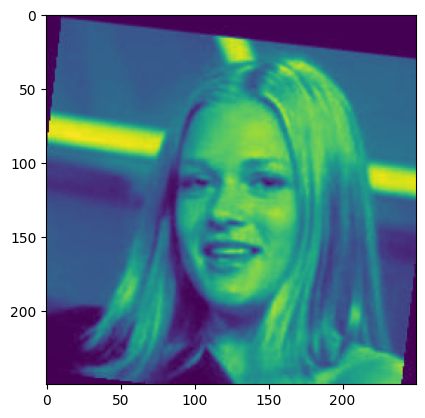

In [81]:
plt.imshow(test_img)

image11.jpg
(250, 250, 3)
(250, 250)
Detected boxes:
x: 80, y: 96, w: 83, h: 83


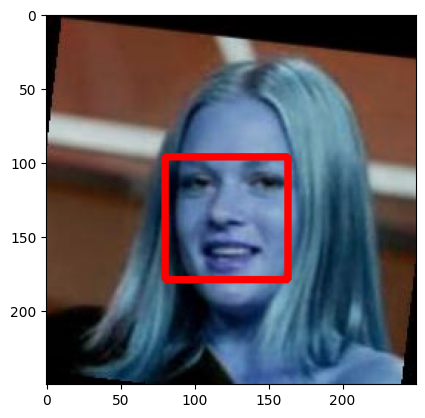

In [86]:
# Esempio test della detection
img = cv2.imread(TEST_PATH)
if img is not None:
    new_size = (int(min(640, img.shape[0])*img.shape[1]/img.shape[0]), min(640, img.shape[0]))
    #print(new_size)
    img = cv2.resize(img, new_size)
    print(im)
    faces_bb_list = detect_faces_sliding_window(TEST_PATH, face_detection_pipeline, overlap_thresh=0.2)

    for (x, y, w, h) in faces_bb_list:
      cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 4)

    plt.imshow(img)
else:
    print("Immagine non caricata correttamente.")

## On a defined images folder

Il seguente repository contiene delle immagini di esempio, su cui runnare il codice, come output verrà prodotta la cartella boxed_images che contiene le stesse immagini con i bounding box, e quindi l'output del programma.

In [93]:
!rm -rf face_detection_sklearn/
!git clone https://github.com/pcorbelli/face_detection_sklearn.git

Cloning into 'face_detection_sklearn'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 38 (delta 3), reused 32 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 1.60 MiB | 14.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [94]:
TEST_IMG_PATH = '/content/face_detection_sklearn/test-images'

In [95]:
!rm -rf boxed_images
if(not os.path.exists('boxed_images')):
  os.mkdir("boxed_images/")

In [96]:
os.listdir(TEST_IMG_PATH)[:]

['images (2).jpeg',
 'image5.jpg',
 'images (3).jpeg',
 'image1.jpg',
 'image4.jpeg',
 'faces-26-site.jpg',
 'image.jpg',
 'image2.jpeg',
 'istockphoto-1447123729-612x612.jpg',
 'storia-della-mia-famiglia-cast-2.jpg',
 'istockphoto-1668207529-612x612.jpg',
 'image8.jpeg',
 'image6.jpeg',
 'image10.jpeg',
 'images.jpeg']

In [97]:
for im in os.listdir(TEST_IMG_PATH):
  img = cv2.imread(TEST_IMG_PATH+ '/' + im)
  if img is not None:
    new_size = (int(min(640, img.shape[0])*img.shape[1]/img.shape[0]), min(640, img.shape[0]))
    #print(new_size)
    img = cv2.resize(img, new_size)
    print(im)
    faces_bb_list = detect_faces_sliding_window(TEST_IMG_PATH+ '/' + im, face_detection_pipeline, overlap_thresh=0.1)

    for (x, y, w, h) in faces_bb_list:
      cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 4)

    cv2.imwrite("boxed_images/"+ 'face_'+ im , img)

images (2).jpeg
(170, 297, 3)
(170, 297)
Detected boxes:
x: 105, y: 42, w: 59, h: 59
x: 60, y: 45, w: 37, h: 37
x: 20, y: 55, w: 37, h: 37
x: 170, y: 25, w: 37, h: 37
image5.jpg
(470, 1200, 3)
(470, 1200)
Detected boxes:
x: 748, y: 204, w: 100, h: 100
x: 238, y: 119, w: 100, h: 100
x: 931, y: 114, w: 150, h: 150
x: 493, y: 153, w: 100, h: 100
images (3).jpeg
(168, 299, 3)
(168, 299)
Detected boxes:
x: 165, y: 45, w: 30, h: 30
x: 90, y: 10, w: 37, h: 37
x: 216, y: 88, w: 60, h: 60
x: 60, y: 100, w: 30, h: 30
image1.jpg
(1080, 1920, 3)
(640, 1137)
Detected boxes:
x: 392, y: 168, w: 227, h: 227
x: 240, y: 336, w: 95, h: 95
image4.jpeg
(183, 275, 3)
(183, 275)
Detected boxes:
x: 114, y: 78, w: 46, h: 46
faces-26-site.jpg
(1920, 2560, 3)
(640, 853)
Detected boxes:
x: 630, y: 399, w: 171, h: 171
x: 63, y: 378, w: 171, h: 171
x: 336, y: 420, w: 171, h: 171
x: 630, y: 90, w: 142, h: 142
x: 54, y: 108, w: 142, h: 142
x: 360, y: 72, w: 142, h: 142
image.jpg
(496, 640, 3)
(496, 640)
Detected boxe

# 7. Conclusions

Come si può vedere molti dei volti nelle immagini vengono correttamente riconosciuti, tuttavia il programma è piuttosto lento e non tutte le detection vengono rilevate correttamente.
Si potrebbe lavorare come improvement sia sull'addestramento che sul'algoritmo di sliding windowing.

# Other stuff (not for the project)

In [ ]:
os.listdir('/content/unsplash-images-collection')[0]

'photo-1637045486754-92ebb723eef9.jpg'

In [ ]:
img_name = os.listdir('/content/unsplash-images-collection')[110]
img1 = cv2.imread(f'/content/unsplash-images-collection/photo-1571816119607-57e48af1caa9.jpg')
img1.shape

(600, 400, 3)

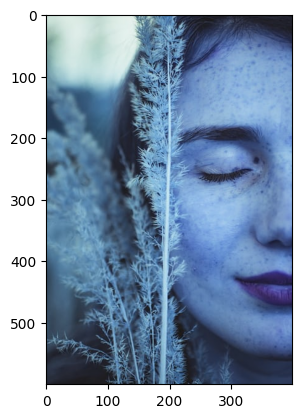

In [ ]:
plt.imshow(img1)

In [ ]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

In [ ]:
gray1.shape

(600, 400)

In [ ]:
fd, hog_image = hog(gray1, orientations=8, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=True)

TypeError: 'cv2.HOGDescriptor' object is not callable

In [ ]:
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

NameError: name 'hog_image' is not defined

NameError: name 'hog_image_rescaled' is not defined

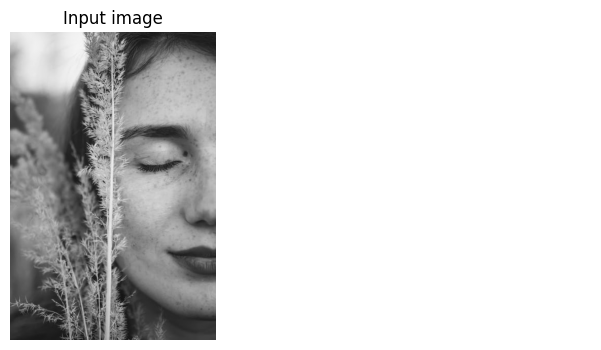

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(gray1, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')


In [ ]:
rnd_start = (np.random.randint(0, img1.shape[0]-64), np.random.randint(0, img1.shape[1]-64))
rnd_start


(448, 99)

In [ ]:
start = (round(img1.shape[0]/2-32), round(img1.shape[0]/2-32)+64)
start = rnd_start
start

(448, 99)

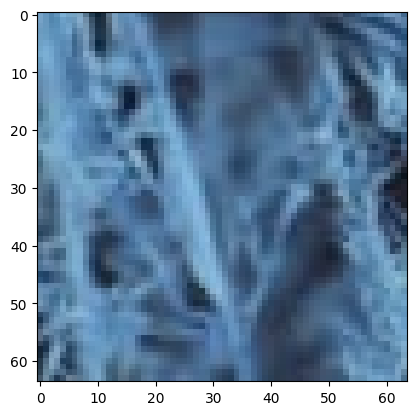

In [ ]:
crop_img = img1[start[0]:start[0]+64, start[1]:start[1]+64]
plt.imshow(crop_img)

In [ ]:
crop_img.shape

(64, 64, 3)